In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy import stats

# import unsupervised ML submodules
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
# load dataset
df1 = pd.read_csv('Country-data.csv')

# inspect dataset
print(df1.info())
print("\n", df1.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None

 (167, 10)


In [3]:
# inspect dataset further
df1.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [4]:
# store countries column for later
countries_col = df1['country']

# drop countries column as it does not contribute to clustering decision
df2 = df1.drop('country', axis=1)

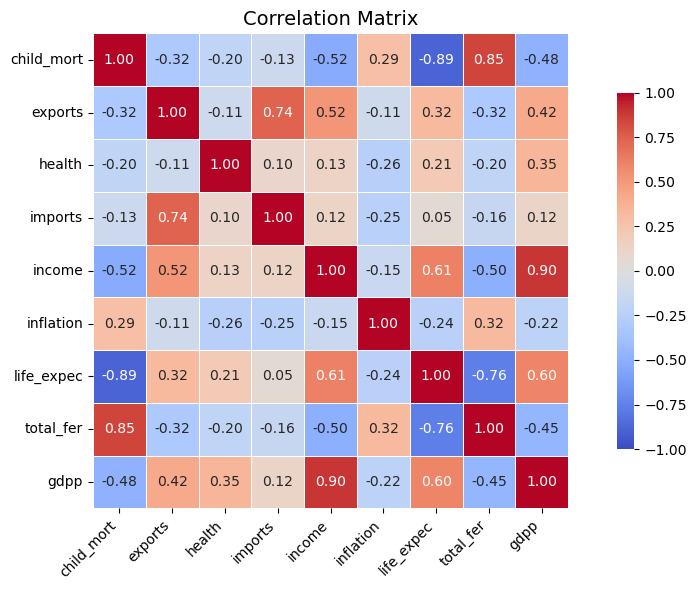

In [5]:
# create and examine correlation matrix
correlation_matrix = df2.corr()

# create heatmap of correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .75})

# add title and labels
plt.title('Correlation Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

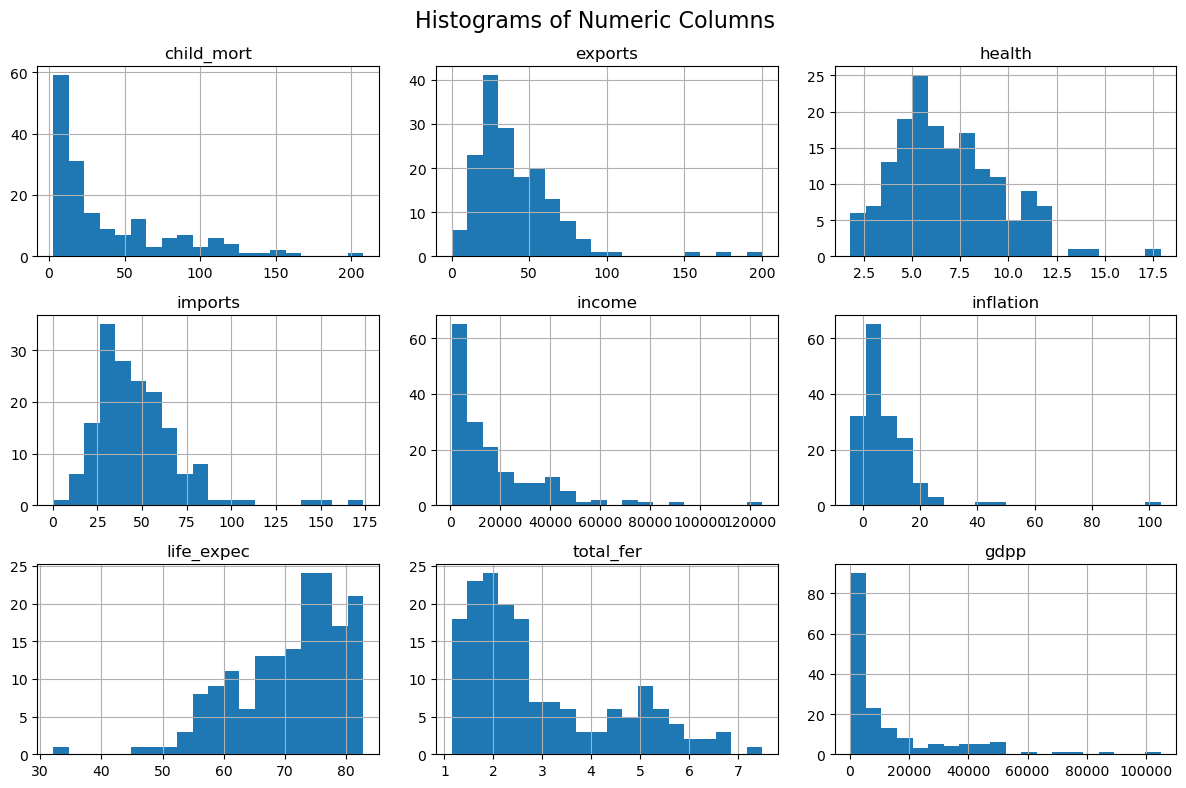

In [6]:
# visualise distribution of columns
df2.hist(bins=20, figsize=(12, 8))

plt.suptitle('Histograms of Numeric Columns', fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
"""No missing values: no nulls or nonsensical zeros. Lots of outliers in every column and uneven skew.
   Only 168 rows, so don't want to remove outliers. Feature clip to re-scale outliers and reduce skewedness"""

# define lists: column buckets to clip
right_skew_cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'total_fer','gdpp']

# feature clip right-skewed cols to remove outliers and reduce skewedness
for col in right_skew_cols:
    lower = df2[col].quantile(0.00)
    upper = df2[col].quantile(0.95)
    df2[col] = df2[col].clip(lower=lower, upper=upper)

# feature clip life_expectancy column, which is left-skewed
df2['life_expec'] = df2['life_expec'].clip(lower=df2['life_expec'].quantile(0.05),
                                                 upper=df2['life_expec'].quantile(1))

/tmp/ipykernel_80333/2434810266.py:11: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2[col] = df2[col].clip(lower=lower, upper=upper)


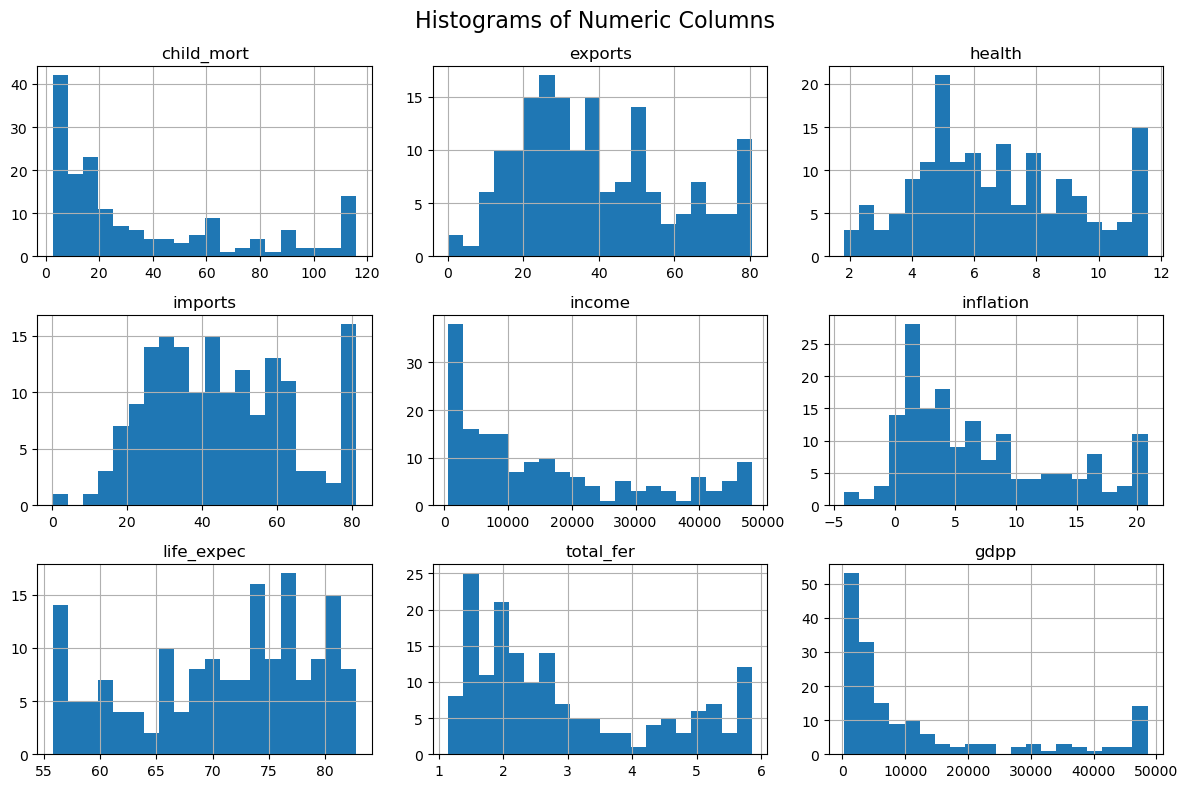

In [8]:
# visualise distribution of clipped columns
df2.hist(bins=20, figsize=(12, 8))

plt.suptitle('Histograms of Numeric Columns', fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
# # split the data into training and evaluation sets
# X_train, X_eval = train_test_split(df2, test_size=0.2, random_state=42)

# ended up not using evaluation, so just using whole dataset for clustering
X = df2.copy()

In [ ]:
# create a list of scalers to try
scalers = [StandardScaler(), RobustScaler(), MinMaxScaler(), PowerTransformer()]

# set up PCA with n=3
pca = PCA(n_components=3)

# create a function to apply scalers, PCA, and KMeans
def apply_scaler_pca_kmeans(scaler, X, n_clusters=2):
    X_scaled = scaler.fit_transform(X)
    X_pca = pca.fit_transform(X_scaled)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    return score, labels, pca.n_components_

# try different scalers and store results
results = []
for scaler in scalers:
    score, labels, n_components = apply_scaler_pca_kmeans(scaler, X)
    results.append((scaler.__class__.__name__, score, labels, n_components))

# print results
for name, score, _, n_components in results:
    print(f"{name}: Silhouette Score = {score:.4f}, PCA components = {n_components}")

# use the best scaler for final clustering
best_scaler = max(results, key=lambda x: x[1])[0]
best_score, best_labels, best_n_components = apply_scaler_pca_kmeans(eval(best_scaler)(), X)

print(f"\nBest Scaler: {best_scaler}")
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Number of PCA components: {best_n_components}")

StandardScaler: Silhouette Score = 0.3509, PCA components = 3
RobustScaler: Silhouette Score = 0.4697, PCA components = 3
MinMaxScaler: Silhouette Score = 0.3868, PCA components = 3
PowerTransformer: Silhouette Score = 0.3866, PCA components = 3

Best Scaler: RobustScaler
Best Silhouette Score: 0.4697
Number of PCA components: 3


Shape of X_pca: (167, 3)


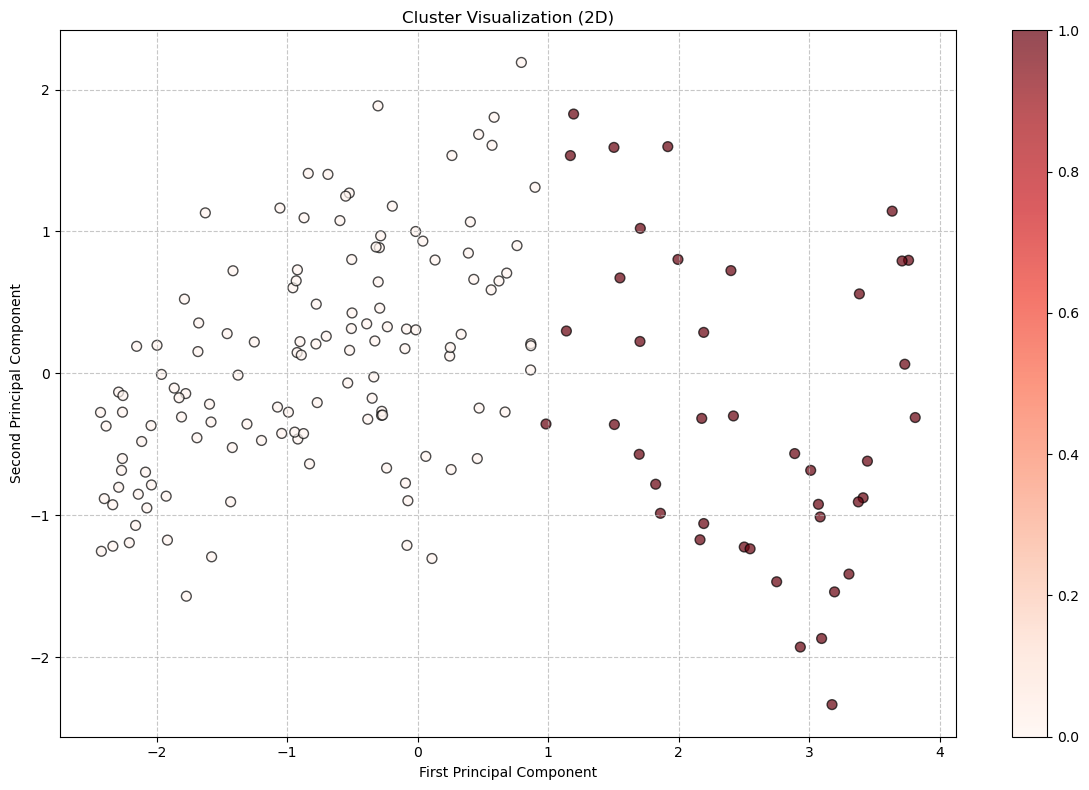

Cluster 0: 126 countries
Cluster 1: 41 countries

Explained Variance Ratio:
[0.54822748 0.14080785 0.11558554]


In [11]:
# apply the best scaler to the data
best_scaler = eval(best_scaler)()
X_scaled = best_scaler.fit_transform(X)

# apply PCA to the scaled data
X_pca = pca.fit_transform(X_scaled)

# check the shape of X_pca
print(f"Shape of X_pca: {X_pca.shape}")

# create a scatter plot
plt.figure(figsize=(12, 8))
 #best_labels is a k-means clustering result, using kmeans.fit_transform() on a KMeans() called kmeans object
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='Reds',  s=50, alpha=0.7, edgecolors='black')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Cluster Visualization (2D)')
plt.colorbar(scatter)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# print the number of countries in each cluster
unique, counts = np.unique(best_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} countries")

# print explained variance ratio
print("\nExplained Variance Ratio:")
print(pca.explained_variance_ratio_)

Feature Importances:
exports       1.157169
gdpp          1.143932
inflation     0.940854
health        0.936435
imports       0.875662
income        0.761135
total_fer     0.598208
child_mort    0.531836
life_expec    0.404959
Name: Total_Importance, dtype: float64


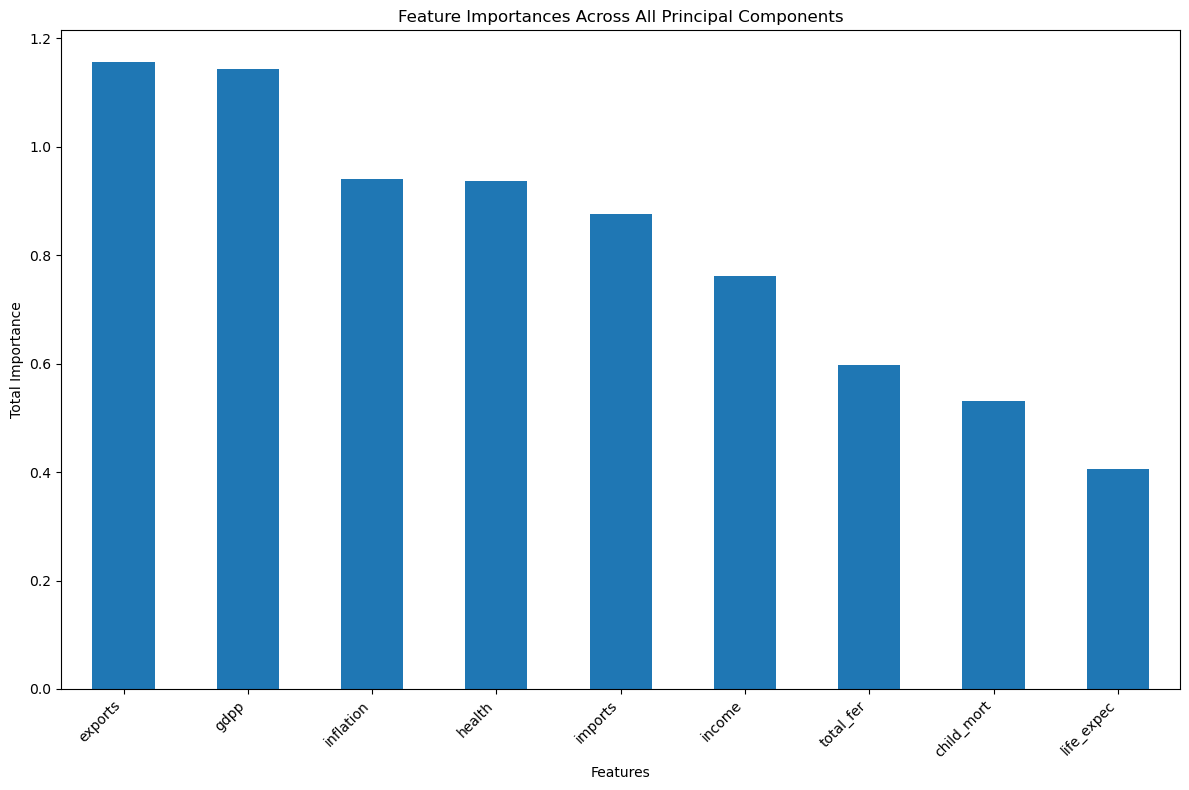

In [12]:
# get the feature names and PCA components
feature_names = X.columns
pca_components = pca.components_

# create an empty dictionary to store PCA components, to pass to a DataFrame
pca_dict = {}

# loop through each PCA component
for i in range(pca_components.shape[0]):
    # create a column names: PC1, PC2 etc.
    column_name = f"PC{i+1}"
    
    # add the component to our dictionary
    pca_dict[column_name] = pca_components[i]

# pass our PCA dictionary to a DataFrame
feature_importance = pd.DataFrame(pca_dict, index=feature_names)

# calculate the importance of each feature across all principal components
feature_importance['Total_Importance'] = feature_importance.abs().sum(axis=1)

# sort features by leve of importance
feature_importance_sorted = feature_importance.sort_values('Total_Importance', ascending=False)

# print the sorted feature by level of importance
print("Feature Importances:")
print(feature_importance_sorted['Total_Importance'])

# visualize feature importance rankings
plt.figure(figsize=(12, 8))
feature_importance_sorted['Total_Importance'].plot(kind='bar')
plt.title('Feature Importances Across All Principal Components')
plt.xlabel('Features')
plt.ylabel('Total Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Explained Variance Ratio for each Principal Component:
PC1: 0.5482
PC2: 0.1408
PC3: 0.1156


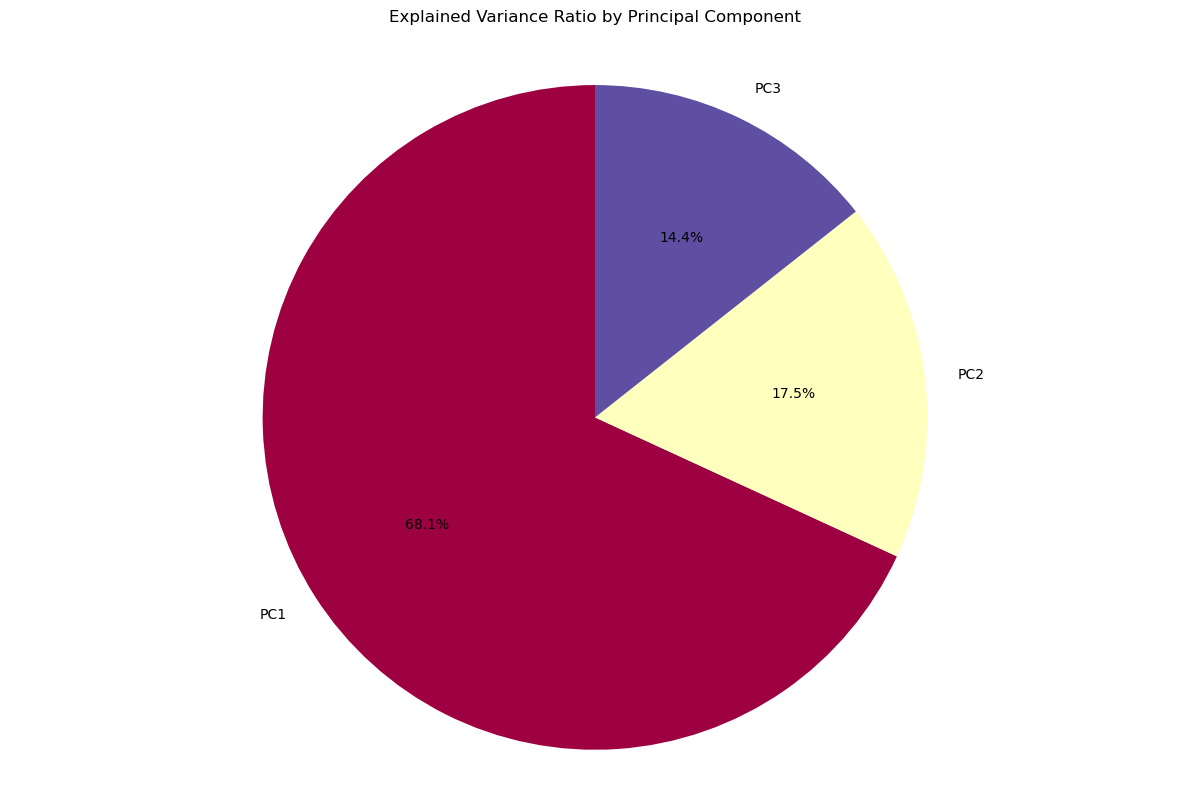

In [13]:
# print explained variance ratio for each component
print("\nExplained Variance Ratio for each Principal Component:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.4f}")

# create a pie chart for explained variance ratio
plt.figure(figsize=(12, 8))
plt.pie(pca.explained_variance_ratio_, 
        labels=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Spectral(np.linspace(0, 1, len(pca.explained_variance_ratio_))))

plt.title('Explained Variance Ratio by Principal Component', y=1.03)
plt.axis('equal')
plt.tight_layout()
plt.show()


Cluster 0:
['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Fiji', 'Gabon', 'Gambia', 'Georgia', 'Ghana', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'India', 'Indonesia', 'Iran', 'Iraq', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kyrgyz Republic', 'Lao', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Lithuania', 'Macedonia, FYR', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Mauritania', 'Mauritius', 'Micronesia, Fed. Sts.', 'Moldo

/tmp/ipykernel_80333/2834120641.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Figure size 2000x1000 with 0 Axes>

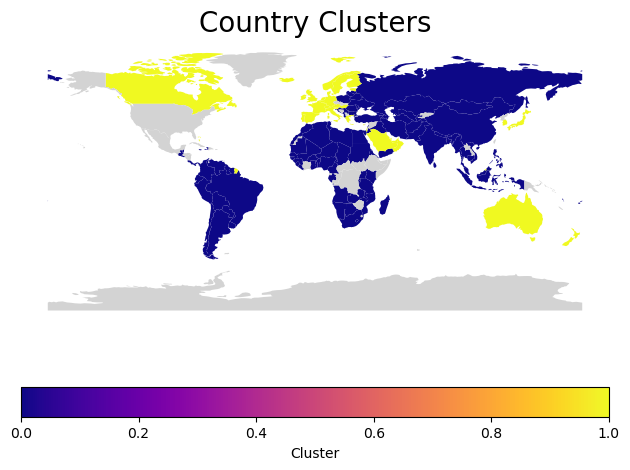

In [14]:
# get the indices of X
train_indices = X.index

# use these indices to select the corresponding countries
train_countries = countries_col[train_indices]

# create the clustered_countries DataFrame
clustered_countries = pd.DataFrame({
    'country': train_countries,
    'cluster': best_labels
})

# print countries in each cluster
for cluster in clustered_countries['cluster'].unique():
    print(f"\nCluster {cluster}:")
    print(clustered_countries[clustered_countries['cluster'] == cluster]['country'].tolist())

# load world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# merge clustered countries with world map data
world = world.merge(clustered_countries, how='left', left_on=['name'], right_on=['country'])

# plot the map
plt.figure(figsize=(20, 10))
ax = world.plot(column='cluster', cmap='plasma', legend=True, 
                legend_kwds={'label': 'Cluster', 'orientation': 'horizontal'},
                missing_kwds={'color': 'lightgrey'})

# remove axis
ax.axis('off')

# add title
plt.title('Country Clusters', fontsize=20)

# show the plot
plt.tight_layout()
plt.show()